# Developing a classifier for houses of multiple or single occupancy

In [1]:
# Load required python libraries
# Data wrangling packages
import sqlite3
import numpy as np
import pandas as pd
import datetime

# Time series modelling packages
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Classification model packages
from sklearn.model_selection import cross_val_score  
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder

# Save model packages
from skl2onnx import to_onnx
import onnxruntime as rt

# Custom functions
from functions import count_events_per_interval, fit_VAR_model, preprocess_events_data

# There is a pandas FutureWarning about using catagorical variables in groupby. Pandas will address this in future updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Attach sqlite data base
connection = sqlite3.connect("../data/data.db")
cursor = connection.cursor()

## Import data from Sqlite database to pandas data frame
Sqlite database consists of two tables; homes and motion. The total database is only about 60 Mb in size so it can be loaded straight into memory (via a pandas dataframe) without overflow concerns.

### homes

homes holds whether the home is a single or multiple occupancy house.

- id is the unique house id, renamed home_id (32 hexadecimal)
- multiple_occupancy is whether house is occupied by more than one person (boolean)

### motion

motion holds each motion detection event as a tuple with four entries

- id is the unique event id, renamed event_id (32 hexadecimal)
- home_id is the unique home id (hexadecimal)
- datetime is the time of the motion detection event (YYYY-MM-DD HH:MM:SS+ss)
- location is the room of house that the motion was detected in (category: living room, conservatory, dining room, study, WC1, hallway, bathroom1, kitchen, lounge, bedroom1)

In [2]:
homes = pd.read_sql_query("SELECT * FROM homes", connection)

# Specify multiple_occupancy as boolean
homes["multiple_occupancy"]=homes["multiple_occupancy"].astype('bool')

# Change id to home_id to be consistent and specific
homes = homes.rename(columns={"id":"home_id"})

In [3]:
motion = pd.read_sql_query("SELECT * FROM motion", connection)

# Specify datetime should be a datetime variable
motion["datetime"] = pd.to_datetime(motion["datetime"])

# Specify location should be a category (This gives a FutureWarning in groupby commands that pandas will address soon)
motion["location"] = motion["location"].astype('category')

# Change id to event_id to be consistent and specific
motion = motion.rename(columns={"id":"event_id"})

In [4]:
motion_homes_join = pd.read_sql_query("""SELECT motion.id as `event_id`, motion.home_id, motion.datetime, motion.location, homes.multiple_occupancy
FROM motion
INNER JOIN homes ON motion.home_id=homes.id;""", connection)

## Initial data exploration

- **is there any missing data** No detected null/na values in imported data.
- **do all home_id's have entries in both tables?**     Of the 106 unique homes in the home data set, there are only 50 unique homes with motion data.
- **are all the events unique?**     There are 580317 events, every event has a unique id.
- **do all homes have the same rooms?**     No, between 2 and 8.
- **are location names unique?** No, mosts homes have lounges but 3 have lounges and living rooms. Most bathrooms, 2 only have WC, some have both.
- **do the events cover the same time period?** Mosts homes have events covering the time period 1st Jan 2024 until 31st Jan 2024. However, one home only has seven days worth of data.
- **are there similar number of events per house?** No, 1000< x <30,000

In [5]:
homes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   home_id             106 non-null    object
 1   multiple_occupancy  106 non-null    bool  
dtypes: bool(1), object(1)
memory usage: 1.1+ KB


In [6]:
motion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580317 entries, 0 to 580316
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   event_id  580317 non-null  object             
 1   home_id   580317 non-null  object             
 2   datetime  580317 non-null  datetime64[ns, UTC]
 3   location  580317 non-null  category           
dtypes: category(1), datetime64[ns, UTC](1), object(2)
memory usage: 13.8+ MB


In [7]:
motion_homes_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580317 entries, 0 to 580316
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   event_id            580317 non-null  object
 1   home_id             580317 non-null  object
 2   datetime            580317 non-null  object
 3   location            580317 non-null  object
 4   multiple_occupancy  580317 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 22.1+ MB


In [8]:
print("Number of unique home_ids in homes table: ", len(homes["home_id"].unique()))
print("Number of unique home_ids in motion table: ", len(motion["home_id"].unique()))
print("Number of unique home_ids in motion-homes combined: ", len(motion_homes_join["home_id"].unique()))

Number of unique home_ids in homes table:  106
Number of unique home_ids in motion table:  50
Number of unique home_ids in motion-homes combined:  50


In [9]:
# Check all home ids are 32 digit hexadecimals
print("All home_id's in the homes table are 32 digit hexadecimals:",len(homes["home_id"]) == sum(homes.home_id.str.match("[0-9abcdef]{32}")))
print("All home_id's in the motion table are 32 digit hexadecimals:",len(motion["home_id"]) == sum(motion.home_id.str.match("[0-9abcdef]{32}")))

All home_id's in the homes table are 32 digit hexadecimals: True
All home_id's in the motion table are 32 digit hexadecimals: True


In [10]:
# Check all event ids are 32 digit hexadecimals
print("All event_id's in the motion table are 32 digit hexadecimals:",len(motion["home_id"]) == sum(motion.event_id.str.match("[0-9abcdef]{32}")))

All event_id's in the motion table are 32 digit hexadecimals: True


In [11]:
print("Number of unique event_ids in motion table: ", len(motion["event_id"].unique()))

Number of unique event_ids in motion table:  580317


In [12]:
rooms_per_home = motion[["home_id","location"]].groupby(["home_id","location"]).head(1).groupby(["home_id"]).count()
print("Homes have between ",min(rooms_per_home["location"])," and ",max(rooms_per_home["location"])," rooms.")
events_per_home = motion[["home_id","event_id"]].groupby(["home_id"]).count()
print("Homes have between ",min(events_per_home["event_id"])," and ",max(events_per_home["event_id"])," events.")

Homes have between  2  and  8  rooms.
Homes have between  1508  and  26472  events.


In [13]:
print("Number of houses with each room type:")
motion[["home_id","location"]].groupby(["home_id","location"]).head(1).groupby(["location"]).count().sort_values("home_id")

Number of houses with each room type:


,home_id
location,
living room,3
conservatory,4
dining room,5
study,5
WC1,16
hallway,41
bathroom1,43
kitchen,43
lounge,45


In [14]:
print("Number of events per room type:")
motion[["location","event_id"]].groupby(["location"]).count().sort_values("event_id")

Number of events per room type:


,event_id
location,
living room,5535
study,5845
conservatory,7715
WC1,10723
dining room,17053
bathroom1,49507
bedroom1,75433
hallway,97011
lounge,153080


In [15]:
homes_with_living_rooms = motion[motion.location == "living room"]["home_id"].unique()
homes_with_lounges = motion[motion.location == "lounge"]["home_id"].unique()
print(len(list(set(homes_with_living_rooms) & set(homes_with_lounges))), "homes have living rooms and lounges")
print("42 homes only have a lounge")
print("No homes only have a living room")

3 homes have living rooms and lounges
42 homes only have a lounge
No homes only have a living room


In [16]:
homes_with_WC = motion[motion.location == "WC1"]["home_id"].unique()
homes_with_bathrooms = motion[motion.location == "bathroom1"]["home_id"].unique()
print(len(list(set(homes_with_bathrooms) & set(homes_with_WC))), "homes have bathroom and water closets")
print("2 homes only have water closets")
print("29 homes only have bathrooms")

14 homes have bathroom and water closets
2 homes only have water closets
29 homes only have bathrooms


In [17]:
# Time period of sensor acquisition
home_sensor_last_entry = motion[["home_id","datetime"]].groupby("home_id").max().rename(columns={"datetime":"enddate"})
home_sensor_first_entry = motion[["home_id","datetime"]].groupby("home_id").min().rename(columns={"datetime":"startdate"})
home_sensor_last_first_combined = pd.merge(home_sensor_first_entry, home_sensor_last_entry, on="home_id")
home_sensor_last_first_combined["difference"] = home_sensor_last_first_combined["enddate"] - home_sensor_last_first_combined["startdate"]
print("The shortest period of sensor data is: ", min(home_sensor_last_first_combined["difference"]))

The shortest period of sensor data is:  7 days 13:24:27


## Data cleaning
To simplify the time series modelling I am going to remove all the event data associated with living room and WC1 locations. All but two homes will still have sensor data in similar rooms. Further exploration is required to determine if these location labels are errors or if these are large homes with multiple receptions rooms/ensuites or if there are multiple sensors in the same rooms. If model performance in these homes is poor we can return to this assumption.

Only a handful of homes have studies/conservatories/dining rooms. For this exploratory analysis I am not going to fit time series models to these data sets. I will add binary labels "has study", "has conservatory", "has dining rooms" as this suggests larger houses with possible multiple occupants. This will give the ML classification some extra data. If model performance in these homes is poor we can return to this assumption.

In order to facilitate the fitting of time series models, I will convert the events based recording to events per 1 day intervals across the entire month of Janurary. I am going to remove the homes with recording periods less than 20 days worth of events detected. The sensor may have only been installed on the 24th of Jan for one house. The other may have gone on holiday from the 16th, for example. The model will not be able to account for such behaviour.

In [18]:
# Remove duplicate rooms and rooms found in less than 10 homes
events_selected_locations = motion[motion.location.str.contains('bedroom1|lounge|bathroom1|hallway|kitchen')]

# Remove the two homes with less than 20 days worth of data
events_selected_locations_homes = events_selected_locations[~events_selected_locations.home_id.str.contains('df9f7afaae7821246e296a41e9e2a6b4|15663392d490688cd4b0e5aa3d5b6ef3')]

In [19]:
homes_with_conservatory = motion[motion.location.str.contains('conservatory')][["home_id"]].groupby(["home_id"]).head(1)

homes_with_conservatory["has_conservatory"] = True

homes_with_dining_room = motion[motion.location.str.contains('dining room')][["home_id"]].groupby(["home_id"]).head(1)

homes_with_dining_room["has_dining_room"] = True

homes_with_study = motion[motion.location.str.contains('study')][["home_id"]].groupby(["home_id"]).head(1)

homes_with_study["has_study"] = True

homes_with_binary_locations = homes_with_conservatory.set_index("home_id")

homes_with_binary_locations = homes_with_binary_locations.join(homes_with_dining_room.set_index("home_id"), how = "outer")

homes_with_binary_locations = homes_with_binary_locations.join(homes_with_study.set_index("home_id"), how = "outer")

homes_with_binary_locations = homes_with_binary_locations.fillna(False)

In [20]:
# Check if any homes still have any time series data post-filter
events_per_home_post_filter = events_selected_locations_homes[["home_id","event_id"]].groupby(["home_id"]).count()
print("Homes have between ",min(events_per_home_post_filter["event_id"])," and ",max(events_per_home_post_filter["event_id"])," events.")

Homes have between  3442  and  21277  events.


In [21]:
# FutureWarning is unactionable and will be solved by pandas team in future
counted_events_per_house = events_selected_locations_homes.groupby(["home_id","location"]).apply(count_events_per_interval, start = "2024-01-01", end = "2024-02-01", interval = "1d", include_groups=False)

# Tidy up dataframe index
counted_events_per_house = counted_events_per_house.reset_index(level=['home_id','location']).reset_index(drop=True)

## Time Series Modeling

A time series model will be fitted to the sensor data of the 5 room types that are common to most homes. The events are discrete integers always greater than 1. Ideally a poisson or neg-bin model should be used for this data. However, a vector autoregressive model with poisson noise would have to be developed (there are limited available python packages for this). 

Instead, I will use a more common vector autoregressive model with gaussian noise for this inital task. Obviously, the continuous noise model with values below zero is not ideal and should be revisited if the model is to be improved. The fact that the data contains a significant number of zeros likely affects the assumption that time series data is stationary. The lag term should be optimised, but as this assessment is not about model performance I shall leave that.

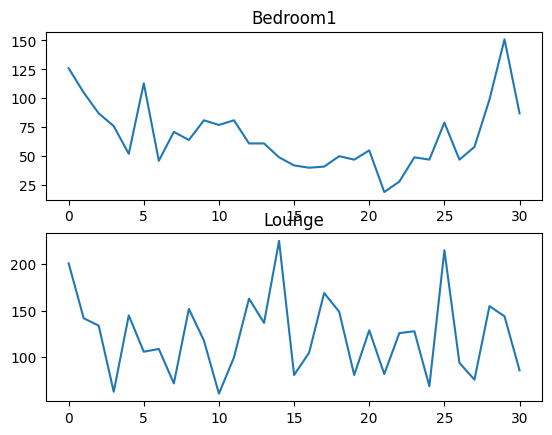

In [22]:
# Visualise count data
test_count_subset_bed = counted_events_per_house[(counted_events_per_house['home_id'] == 'f5a2b27c9d8bb7f59b7b0684d3555e52') & (counted_events_per_house['location'] == 'bedroom1')]['event_count']
test_count_subset_lounge = counted_events_per_house[(counted_events_per_house['home_id'] == 'f5a2b27c9d8bb7f59b7b0684d3555e52') & (counted_events_per_house['location'] == 'lounge')]['event_count']
fig, ax = plt.subplots(nrows=2, ncols=1)  # Create a figure containing a single axes.
ax[0].plot(range(31), test_count_subset_bed)  # Plot some data on the axes.
ax[0].title.set_text("Bedroom1")
ax[1].plot(range(31), test_count_subset_lounge)  # Plot some data on the axes.
ax[1].title.set_text("Lounge")

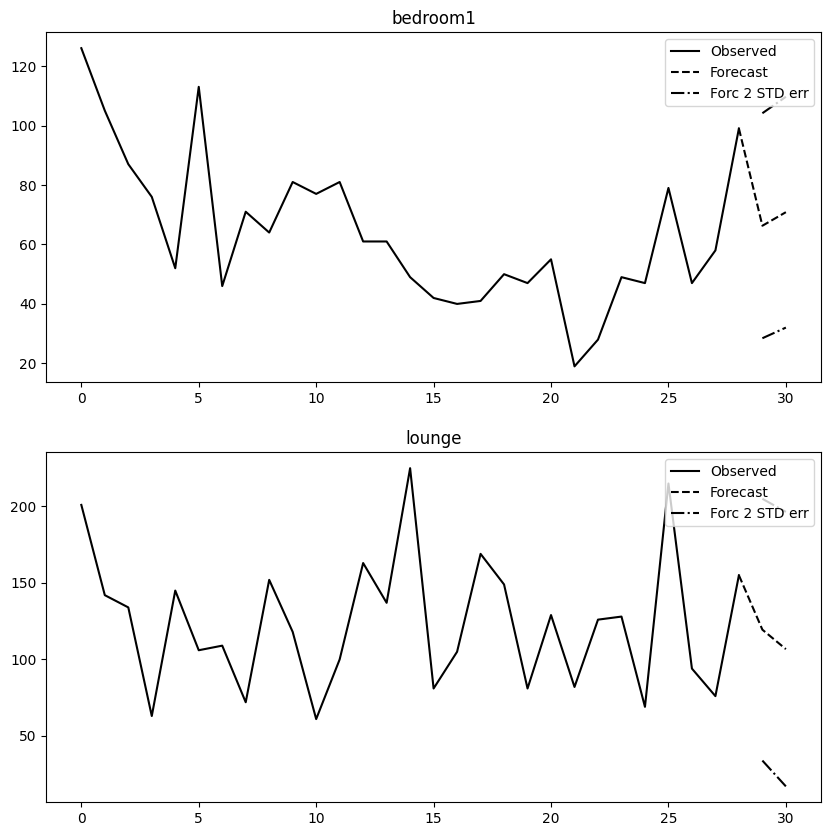

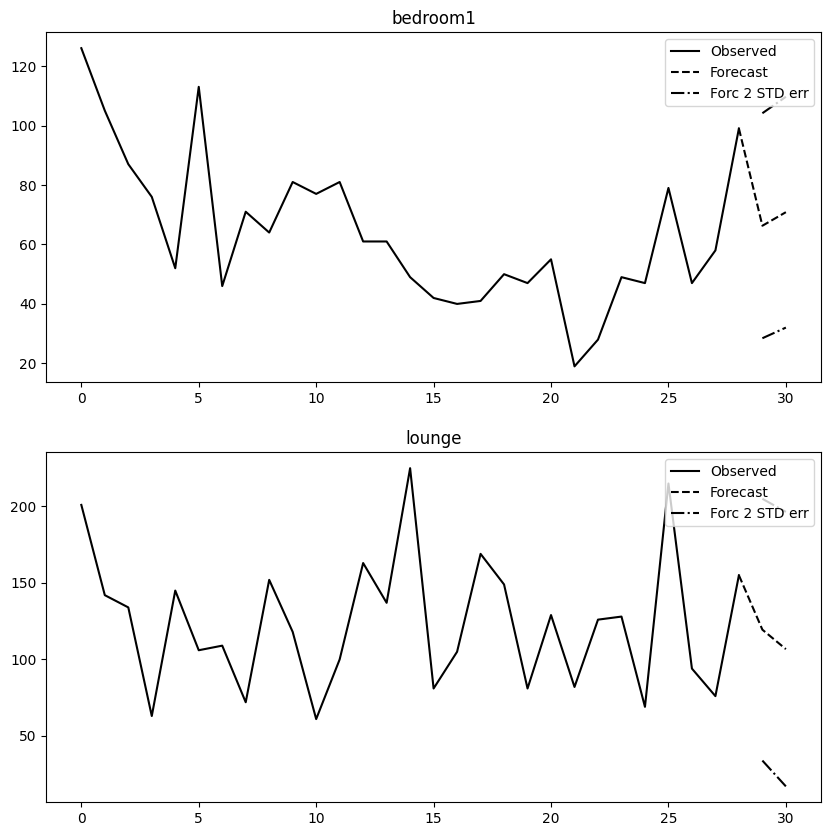

In [23]:
# Check vector autoregression model forcasts resonable results
test_model_fit = counted_events_per_house[(counted_events_per_house['home_id'] == 'f5a2b27c9d8bb7f59b7b0684d3555e52')].pivot_table(index="datetime",values="event_count", columns="location")
#test_model_fit = np.log(test_model_fit)
model = VAR(test_model_fit.iloc[0:29], freq = "D")
results = model.fit(2)
results.forecast(test_model_fit.values[28:], 2)
results.plot_forecast(2)

In [24]:
# Apply model to all homes
modelled_event_counts = counted_events_per_house.groupby("home_id").apply(fit_VAR_model, lag=2, freq="D", include_groups=False)
# Move index to column names
modelled_event_counts = modelled_event_counts.reset_index(level='home_id')
modelled_event_counts["coefficient"] = modelled_event_counts.index
modelled_event_counts = modelled_event_counts.reset_index(drop=True)
# Pivot all coefficients to column values and flatten column name hierchy 
modelled_event_counts = modelled_event_counts.pivot(columns="coefficient", index="home_id")
modelled_event_counts.columns = [' '.join(col).strip() for col in modelled_event_counts.columns.values]
# Set missing vector autoregression coefficients to 0
modelled_event_counts = modelled_event_counts.fillna(0)
# Join results with binary data to prepare for classification
modelled_event_counts = modelled_event_counts.join(homes_with_binary_locations).fillna(False)

## Classification

The data is tabular, has a limited number of data points and contains continuous and boolean variables. The limited amount of training data suggests the use of a deep learning model would be difficult. The complicated relationship between movement behaviour and sensor recording suggest a linear regression model will not likely be sucessful. Instead, I will use a decision tree based approach to achieve a reasonable result on a non-linear relationship with a limited data set. Gradiant boosted decision trees can also conduct feature selection if the split is based on < n_features. 

As the training data set, is small and the quality of data acquired from each home is highly varying I will test the model using 10-fold cross validation rather than explicitly withholding a subset of the data for validation. 

In [25]:
# Create train data set
encoder = LabelEncoder()

# Normalise features
event_data = modelled_event_counts

HMO_value = modelled_event_counts.join(homes.set_index('home_id'))['multiple_occupancy']
HMO_value = encoder.fit_transform(HMO_value)

In [26]:
# Test model
np.random.seed(159)

mdl = ensemble.GradientBoostingClassifier(n_estimators=15, max_depth=4, max_features='sqrt')

scores = cross_val_score(mdl, event_data.values, HMO_value, cv=10)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.70 accuracy with a standard deviation of 0.22


In [27]:
# Package model as ONNX
mdl = mdl.fit(event_data, HMO_value)

onx = to_onnx(mdl, event_data.values[:1].astype(np.float32))
with open("HMO_classifer.onnx", "wb") as f:
    f.write(onx.SerializeToString())

## Conclusions

Fitting a gradient boosted decision tree on features derived by vector autoregression models is a successful method for determining if a home has a single or multiple occupants. The model can reliably predict the home's occupants in over 2/3 of cases. There is quite a lot of variation in model performance across homes, which would need to be improved. There remains plenty of variables to refine (across the initial feature selection, the time-series modelling and the decision tree fitting).

In [28]:
# Example run through on new data
# Use one of the two homes not used to train model

new_home_event_raw = motion[motion.home_id.str.contains('15663392d490688cd4b0e5aa3d5b6ef3')]

new_event_data = preprocess_events_data(new_home_event_raw, end = "2024-01-17")

In [29]:
sess = rt.InferenceSession("HMO_classifer.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: new_event_data.values.astype(np.float32)})[0]

In [30]:
pred_onx[0] == homes[homes.home_id.str.contains('15663392d490688cd4b0e5aa3d5b6ef3')][["multiple_occupancy"]].values[0][0]

True